# Remove Redundant Data

In [8]:
import pandas as pd

# Reading a CSV file into a DataFrame, selecting specific columns
fields = ['item_description']
df = pd.read_csv('order_details_202505141508.csv', usecols=fields)

# use for loop to print first 10 rows of the DataFrame
for i in range(20):
    print(df.iloc[i].values[0])

Place Packing List Inside Box and Stamp Box
5 PIECES PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
50 EACH OF ITEM COLOR IN ONE BOX
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
APPLY BARCODE LABELS TO EACH ITEM
5 PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Apply Fragile and Directional labels to all cartons.
Place Packing List Inside Box and Stamp Box
Special Package - POLYBAG ONE OF EACH COLOR
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box	
Place Packing List Inside Box and Stamp Box
3 OF THE FEMALE & 3 OF THE MALE PHYSICIAN IN ONE POLY BAG


In [9]:
import re

print(df.shape)
print("\n\nAfter removing duplicates")
df['item_description'] = df['item_description'].str.lower() # there are lots of words with the same meaning but different cases
print(df.shape)

def clean_data(text):
    # apply number masking to reduce sensitivity to specific quantity values
    text = re.sub(r'\b\d+(\.\d+)?\b', '<NUM>', text)#\b means word boundary. \d+ means Match 1 or more digits
    # remove non-informative puncutuation
    text = re.sub(r'[-:*"\'.,]', '', text)
    # remove non-informative words
    text = re.sub(r'\b(please|kindly)\b', '', text) 
    # remove repeated spaces
    text = re.sub(r'\s+', ' ', text) # \s+ = one or more whitespace character
    # remove "special package"
    text = re.sub(r'\b(special package|special packaging)\b', '', text)

    return text



df['item_description'] = df['item_description'].apply(clean_data)



# remove duplicates
df.drop_duplicates(inplace=True)
print(df.shape)

for i in range(20):
    print(df.iloc[i].values[0])

# turn it into a list
item_list = df['item_description'].tolist()
print(len(item_list))

(34938, 1)


After removing duplicates
(34938, 1)
(2975, 1)
place packing list inside box and stamp box
<NUM> pieces per polybag
<NUM> each of item color in one box
apply barcode labels to each item
<NUM> per polybag
apply fragile and directional labels to all cartons
 polybag one of each color
place packing list inside box and stamp box 
<NUM> of the female & <NUM> of the male physician in one poly bag
<NUM> item per poly bag
boxes of <NUM>
 <NUM> per box
 <NUM> per polybag
packages of <NUM>
yellow msbcom labels to outside of all shipping cartons
<NUM> box assorted items
attach nfl hologram sticker
 packs of <NUM>
<NUM> of each color per box
<NUM> of each color per box <NUM> full boxes
2975


# UMAP + HDBSCAN 

UMAP is often preferred for larger datasets or when maintaining both global and local patterns is crucial, while t-SNE might be used for finer cluster analysis in smaller datasets. PCA is generally faster and preferred for preliminary analysis or when the relationships in the data are primarily linear.
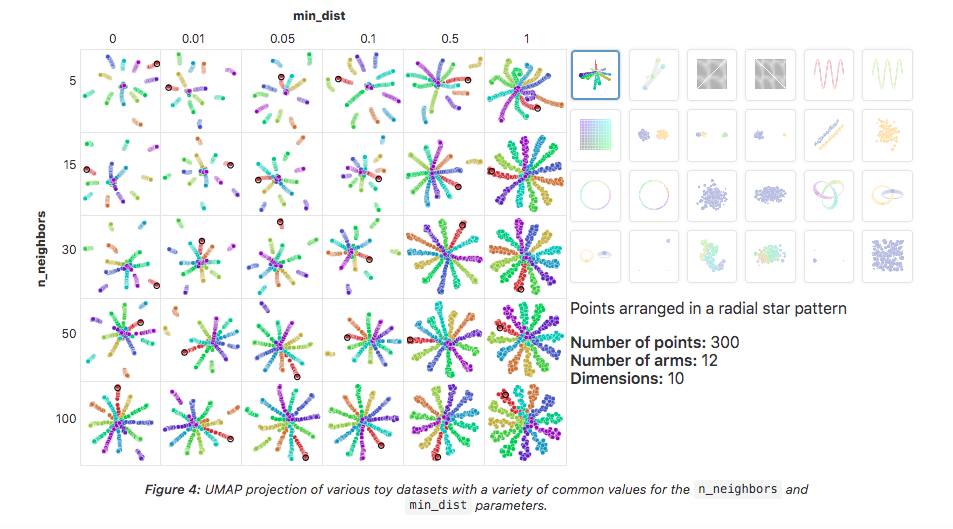

https://pair-code.github.io/understanding-umap/

In [ ]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import random
import numpy as np

# set the random seed for reproducibility
random.seed(32)                
np.random.seed(32)             

# load the model
model = SentenceTransformer('all-MiniLM-L6-v2')
# encode the sentences
embeddings = model.encode(item_list, show_progress_bar=True)

# reduce the dimensionality of the embeddings. 
# n_neighbors is the number of neighbors to consider when constructing the UMAP graph. For noisy data, larger n_neighbors may produce more stable embeddings.
# n_components is the number of dimensions to reduce to(output dimension). Use 2 for visulization purposes, try 5 later!
reducer = umap.UMAP(n_neighbors=200, n_components=250, metric='cosine', random_state=32)
embeddings = reducer.fit_transform(embeddings)

# reducer = umap.UMAP(n_neighbors=200, n_components=200, metric='cosine'
# 32 686, 33 674, 34 677
# reducer = umap.UMAP(n_neighbors=200, n_components=250, metric='cosine'
# 32 xxx, 33 628, 34 674


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

c:\Users\AlanC\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [38]:
# clustering the reduced embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', prediction_data=True) # for min_cluster_size, Smaller → more (and smaller) clusters, Larger → fewer, more robust clusters

# fit the HDBSCAN model to the reduced embeddings
clusterer.fit(embeddings)
# get the cluster labels
labels = clusterer.labels_

In [39]:
import random
from collections import defaultdict

# for reproducibility
random.seed(42)  

# Create a dictionary to hold sentences by cluster
cluster_dict = defaultdict(list)

# Fill the dictionary
for label, sentence in zip(clusterer.labels_, item_list):
    cluster_dict[label].append(sentence)

# Display a few clusters
for label in sorted(cluster_dict.keys()):
    print(f"\n=== Cluster {label} ===")
    cluster = cluster_dict[label]

    # randomly select 5 sentences from the cluster
    sample_size = min(15, len(cluster))
    sample = random.sample(cluster, sample_size) 
    
    for sentence in sample:
        print(f"{sentence}")
    if len(cluster) > 15:
        print(f"...and {len(cluster) - 15} more\n")


=== Cluster -1 ===
supplied cat license applied to outside gift box 
green orane purple red in a poly bag

see bill for returned pieces
add <NUM> cust supplied upc sticker to each item n/c
insert bottles in the wsagg11bl straps
put the black plates on the headphones
 <NUM> per pack assorted <NUM> green/<NUM> blue/<NUM> orange
 customer letter in box
packs of <NUM> qty per brand
each order will be on a separate pallet
standard pkg
pack in flats of <NUM> piggy banks
one box
ship in original packaging do not repack
...and 674 more


=== Cluster 0 ===
joo kim
ann fink
patricia sonnett
tod bowermaster
erik harris
alla voskoboynikova
andrew cuneo
zac minor
robert walker
hannah ji
jelena dirks
erin schreiber
name on bottle should be sara chomack
jennifer mazzoni
mary edwards
...and 55 more


=== Cluster 1 ===
print bilingual instructions on polybag whfbd10bl
print bilingual instructions on polybag wpchs20wh
print bilingual instructions on polybag wkaom15rd
print bilingual instructions on pol

# Visualization 

c:\Users\AlanC\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


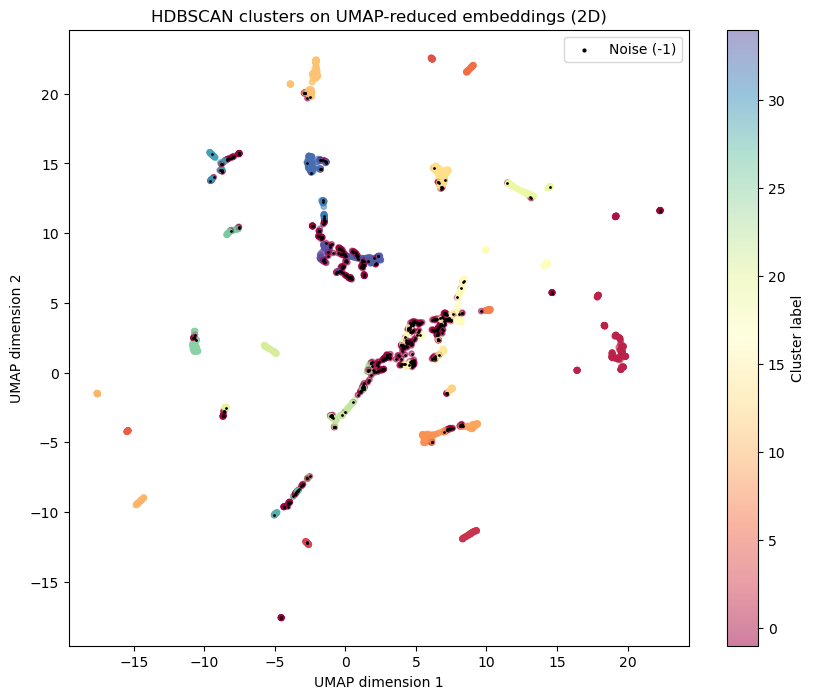

In [17]:
import umap
import matplotlib.pyplot as plt

# 1. Re‑embed into 2D for visualization
reducer_2d = umap.UMAP(
    n_neighbors=30,
    n_components=2,
    metric='cosine',
    random_state=42
)
embeds_2d = reducer_2d.fit_transform(embeddings)  # embeddings from your SentenceTransformer step

# 2. Scatter‑plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeds_2d[:, 0],
    embeds_2d[:, 1],
    c=labels,                  # labels from HDBSCAN
    cmap='Spectral',           # nice categorical palette
    s=15,                       # point size
    alpha=0.5                  
)
plt.colorbar(scatter, label='Cluster label')
plt.title('HDBSCAN clusters on UMAP-reduced embeddings (2D)')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')

# 3. Optional: highlight noise points
noise_mask = labels == -1
plt.scatter(
    embeds_2d[noise_mask, 0],
    embeds_2d[noise_mask, 1],
    # show noise points in transparent
    # alpha=0, # comment out to see them
    c='black',
    s=1,
    label='Noise (-1)'
)
plt.legend(markerscale=2, frameon=True)
plt.show()


# Save the Model

In [16]:
import joblib

# Save UMAP reducer and HDBSCAN clusterer
joblib.dump(reducer, 'my_umap_reducer_cleaned_data.pkl')
joblib.dump(clusterer, 'my_hdbscan_clusterer_cleaned_data.pkl')

['my_hdbscan_clusterer_cleaned_data.pkl']